In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm, trange

%matplotlib inline

## Конфигурация

In [2]:
config = dict(
    n_epochs=50,
    batch_size=128,
    learning_rate=1e-6
)

## Dataset

In [3]:
class SiameseDataset(torch.utils.data.Dataset):

    def __init__(self, path, x_file='x.pt', y_file='y.pt'):
        self.x = torch.load(path + '/' + x_file)
        self.y = torch.load(path + '/' + y_file)
        
        if self.x.shape[0] != self.y.shape[0]:
            raise RuntimeError(f'Tensors X and Y must have the same number of items.')

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx][0], self.x[idx][1], self.y[idx]

## Нейронная сеть

In [4]:
class SiameseNetwork(torch.nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=8, out_channels=12, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=12, out_channels=16, kernel_size=3),
            torch.nn.ReLU(),
        )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(416, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2),
        )

    def forward_once(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def forward(self, x_1, x_2):
        out_1 = self.forward_once(x_1)
        out_2 = self.forward_once(x_2)

        return out_1, out_2

## Контрастная функция потерь

In [5]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, out_1, out_2, y):
        euclidean_distance = torch.nn.functional.pairwise_distance(out_1, out_2, keepdim=True)
        
        loss_contrastive = torch.mean((1 - y) * torch.pow(euclidean_distance, 2) +
                                      (y) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive

## Обучение нейросети

#### Подготовка Dataset и DataLoader

In [6]:
train_dataset = SiameseDataset(path='siamese_data/train')

In [7]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               shuffle=True,
                                               batch_size=config['batch_size'])

#### Обучение

In [8]:
model = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [9]:
def lr_lambda_1(epoch):
    T_max = 15
    lr_max = 1.0
    lr_min = 0.05

    if epoch <= T_max:
        return lr_min + (lr_max - lr_min) * (1.0 + np.cos(np.pi * epoch / T_max)) / 2.0
    
    return lr_min

def lr_lambda_2(epoch):
    T_max = config['n_epochs']
    lr_max = 1.0
    lr_min = 0.05

    return lr_min + (lr_max - lr_min) * (1.0 + np.cos(np.pi * epoch / T_max)) / 2.0

def lr_lambda_3(epoch):
    return 0.1 ** (epoch // 10)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda_2)

In [10]:
loss_history = []
epoch_loss_history = []
lr_history = []

epoch_progress = trange(config['n_epochs'])
for epoch in epoch_progress:
    epoch_progress.set_description(f'Epoch {epoch + 1}')

    for i, (x_1, x_2, y) in enumerate(train_dataloader):
        out_1, out_2 = model(x_1, x_2)

        loss = criterion(out_1, out_2, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history.append(loss.item())

    lr_history.append(optimizer.param_groups[0]['lr'])
    epoch_loss_history.append(np.mean(loss_history[-len(train_dataloader):]))

    scheduler.step()

    epoch_progress.set_postfix({'epoch_mean_loss': epoch_loss_history[-1]})

  0%|          | 0/50 [00:00<?, ?it/s]

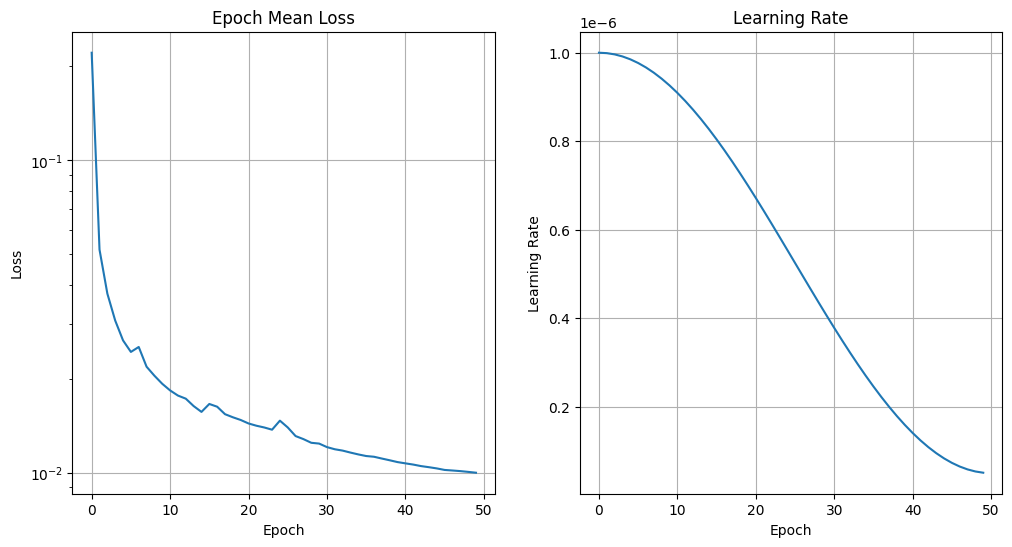

In [11]:
fig, axis = plt.subplots(1, 2, figsize=(12, 6))

# Epoch Mean Loss plot
axis[0].set_title('Epoch Mean Loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].semilogy()
axis[0].grid()
axis[0].plot(epoch_loss_history)

# Learning Rate plot
axis[1].set_title('Learning Rate')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Learning Rate')
axis[1].grid()
axis[1].plot(lr_history)

## Тестирование нейросети

#### Подготовка Dataset и DataLoader для тестирования

In [12]:
test_dataset = SiameseDataset(path='siamese_data/test')

In [13]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=len(test_dataset))

#### Расчет метрик

In [14]:
losses = []

for i, (x_1, x_2, y) in enumerate(test_dataloader):
    with torch.inference_mode():
        out_1, out_2 = model(x_1, x_2)
        dist = torch.nn.functional.pairwise_distance(out_1, out_2, keepdim=True)
        loss = criterion(out_1, out_2, y)
        losses.append(loss.item())

X = torch.cat((y, dist), 1)

print(f'Loss = {np.mean(losses)}')
print(f'Distance range between identical objects: [{X[X[:, 0] == 0, :][:, 1].min()}, {X[X[:, 0] == 0, :][:, 1].max()}]')
print(f'Distance range between different objects: [{X[X[:, 0] == 1, :][:, 1].min()}, {X[X[:, 0] == 1, :][:, 1].max()}]')

Loss = 0.015015661716461182
Distance range between identical objects: [0.00012880071881227195, 1.1722840070724487]
Distance range between different objects: [28.46622085571289, 979.4330444335938]


## Отладка результатов

In [18]:
debug = True

In [19]:
debug_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               shuffle=True,
                                               batch_size=1)

In [20]:
if debug:
    for i, (x_1, x_2, y) in enumerate(debug_dataloader):
        with torch.inference_mode():
            out_1, out_2 = model(x_1, x_2)
        
            dist = torch.nn.functional.pairwise_distance(out_1, out_2, keepdim=True)

            loss = criterion(out_1, out_2, y)

            print('x_1:')
            print(x_1)
            print('x_2:')
            print(x_2)
            print(f'Actual: {y.item()}')
            print(f'out_1 = {out_1}')
            print(f'out_2 = {out_2}')
            print(f'd(out_1, out_2) = {dist.item()}')
            print(f'loss = {loss.item()}')
        
            _ = input()

x_1:
tensor([[[224900.0000, 225150.0000, 225400.0000, 225650.0000, 225900.0000,
          226150.0000, 226400.0000, 226650.0000, 226900.0000, 227150.0000,
          227400.0000, 227650.0000, 227900.0000, 228150.0000, 228400.0000,
          228650.0000, 228900.0000, 229150.0000, 229400.0000, 229650.0000,
          229900.0000, 230150.0000, 230400.0000, 230650.0000, 230900.0000,
          231150.0000, 231400.0000, 231650.0000, 231900.0000, 232150.0000,
          232400.0000, 232650.0000],
         [424002.7188, 424009.0312, 424014.6250, 424020.9062, 424027.3750,
          424033.7812, 424038.6875, 424045.7188, 424052.2812, 424058.5625,
          424064.8125, 424069.8750, 424075.6875, 424083.5312, 424089.4688,
          424094.5625, 424101.1875, 424107.0625, 424114.2500, 424119.9375,
          424125.6250, 424132.6875, 424137.4688, 424144.2188, 424150.6562,
          424157.2500, 424163.3750, 424169.8750, 424175.2188, 424181.7812,
          424186.5625, 424193.2812],
         [685999.3750

x_1:
tensor([[[ 166250.0000,  166500.0000,  166750.0000,  167000.0000,  167250.0000,
           167500.0000,  167750.0000,  168000.0000,  168250.0000,  168500.0000,
           168750.0000,  169000.0000,  169250.0000,  169500.0000,  169750.0000,
           170000.0000,  170250.0000,  170500.0000,  170750.0000,  171000.0000,
           171250.0000,  171500.0000,  171750.0000,  172000.0000,  172250.0000,
           172500.0000,  172750.0000,  173000.0000,  173250.0000,  173500.0000,
           173750.0000,  174000.0000],
         [-960115.7500, -960153.8750, -960192.3125, -960231.7500, -960269.6250,
          -960308.8750, -960347.6875, -960387.0000, -960425.3125, -960462.8125,
          -960501.1875, -960540.8750, -960579.7500, -960618.3125, -960656.1250,
          -960694.3125, -960734.1250, -960771.6875, -960810.1875, -960848.9375,
          -960887.6250, -960926.6250, -960965.4375, -961003.1250, -961041.5625,
          -961080.6250, -961118.1875, -961158.4375, -961195.6875, -961234.00

KeyboardInterrupt: Interrupted by user